# Devoir 3 &mdash; Images Panoramiques
## Récupération des fichiers dans Colab

In [ ]:
#
# Exécutez cette cellule pour préparer votre environnement Colab.
#
# %%capture
# !wget https://benhadid.github.io/m1vpo/static_files/assignments/hw2.zip
# !unzip hw2.zip
# !mv hw2/* .
# !rm -rf hw2
# !rm -rf hw2.zip

## Initialisation du bloc-notes

In [1]:
from __future__ import print_function

# Setup
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 12) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# configurer Numpy pour afficher trois decimals après la virgule
#np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
np.set_printoptions(precision=3)

# pour le rechargement automatique des modules externes
%load_ext autoreload
%autoreload

## données références pour validation des TODOs
loaded = np.load('./arrays.npz', allow_pickle=True)

## 1. Description

L'assemblage d'images en panorama est un très grand succès de la Vision Par Ordinateur. Matthew Brown et David G. Lowe ont publié un célèbre [article](https://drive.google.com/file/d/1qB54hR4TS_7But2KKkvuk6jTV1uWg8Tf/view?usp=sharing) sur cette technique en 2007. Depuis lors, cette technologie a été largement adoptée dans de nombreuses applications telles que "**Google Street View**" et les prises d'images panoramiques sur les smartphones.

Dans ce devoir, vous allez implémenter une solution pour combiner une série d'images se chevauchant en une seule image panoramique. La détection des points-clés dans les images et un appariement initial est déjà fourni dans le code de démarrage (usage de fonctions ORB de OpenCV).

Dans un premier temps, vous implémenterez le code qui calcule la matrice de transformation homographique entre deux images à partir de paires de correnspondance de points-clés. Ensuite, vous coderez une fonction pour séparer les bonnes correspondances (inliers) des mauvaises (outliers) selon le principe de l'algorithme [RANdom SAmple Consensus - RANSAC](https://en.wikipedia.org/wiki/Random_sample_consensus). Cela permetra l'alignement automatiquement des images de façpn robuste (positions relatives les unes par rapport aux autres ainsi que le calcul des zones de chevauchements de celles-ci). En troisième étape, afin d'appliquer les opérations de projections des images en un panorama, vous coderez l'algorithme de projection bilineaire inverse discuté en [cours](). Enfin, les images résultantes devraient être fusionnées en un seul panorama homogène (suppression des effets de bord dans l'image finale).

Pour résumer, les étapes requises pour créer un panorama sont enumérées ci-dessous. Celles que vous devez implémenter dans ce devoir sont indiquées en gras :

1. Extraire les primitives dans les images
2. Mise en correspondance des primitives
3. **Calcul de la matrice de transformation**
4. **Alignement des images à l'aide de RANSAC**
5. **Projection et interpolation des images**
4. **Fusion des images en une image panoramique**

## 2. Règles de codage

**<span style='color:Red'>
NE MODIFIEZ PAS LE CODE SQUELETTE EN DEHORS DES BLOCS TODO.<br>L'EVALUATEUR AUTOMATIQUE SERA TRES MECHANT AVEC VOUS SI VOUS LE FAITES !
</span>**

### 2.1. Résumé des fonctions potentiellement utiles (vous n'êtes pas obligé de les utiliser)  
- numpy.divide,
- numpy.eye,
- numpy.ndarray,
- numpy.dot,
- numpy.linalg.svd,
- numpy.linalg.lstsq,
- numpy.linalg.inv,
- numpy.meshgrid

### 2.2. Résumé des fonctions <span style='color:Red'>interdites</span>
- cv2.findHomography,
- cv2.perspectiveTransform,
- cv2.warpPerspective,
- cv2.remap,
- cv2.getAffineTransform,
- cv2.getPerspectiveTransform,
- cv2.invertAffineTransform,
- cv2.warpAffine,
- skimage.transform.ProjectiveTransform,
- skimage.measure.ransac,
- skimage.transform.SimilarityTransform,
- skimage.transform.AffineTransform,
- skimage.transform.FundamentalMatrixTransform,
- skimage.transform.warp,
- skimage.transform.warp_coords

Vous pouvez utiliser ces fonctions pour le débogage de votre code, mais la version finale ne doit en aucun cas les inclure faute d'avoir un zéro pour le devoir.


## 3. Préparation des données (détection des points-clés et appariemment initial)

Dans la cellule suivante, nous exécutons un algorithme de détéction de coins sur deux images, et récupérons les descripteurs associés à ces clés. Ensuite, nous effectuons une mise en correspondance entre les deux images et affichons l'ensemble des résultats.

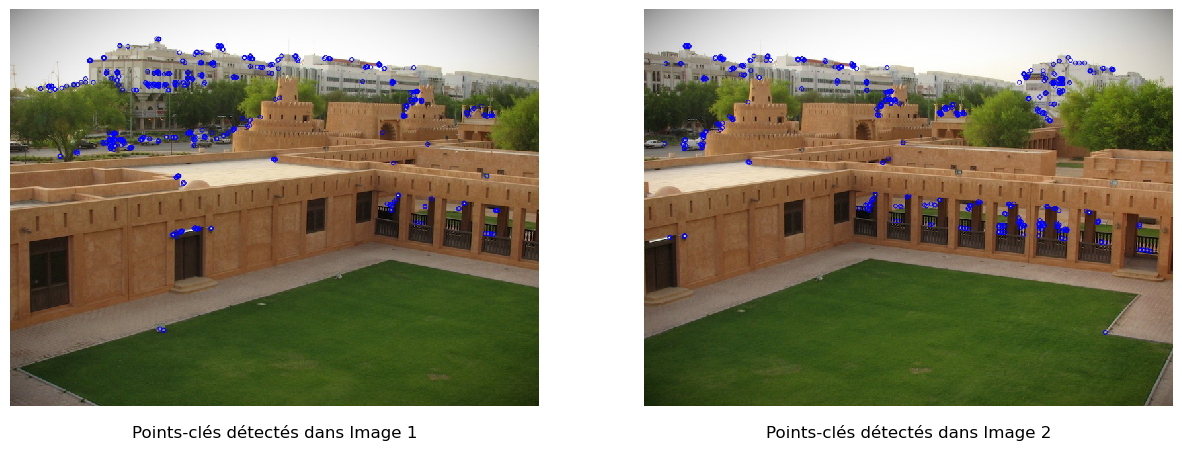

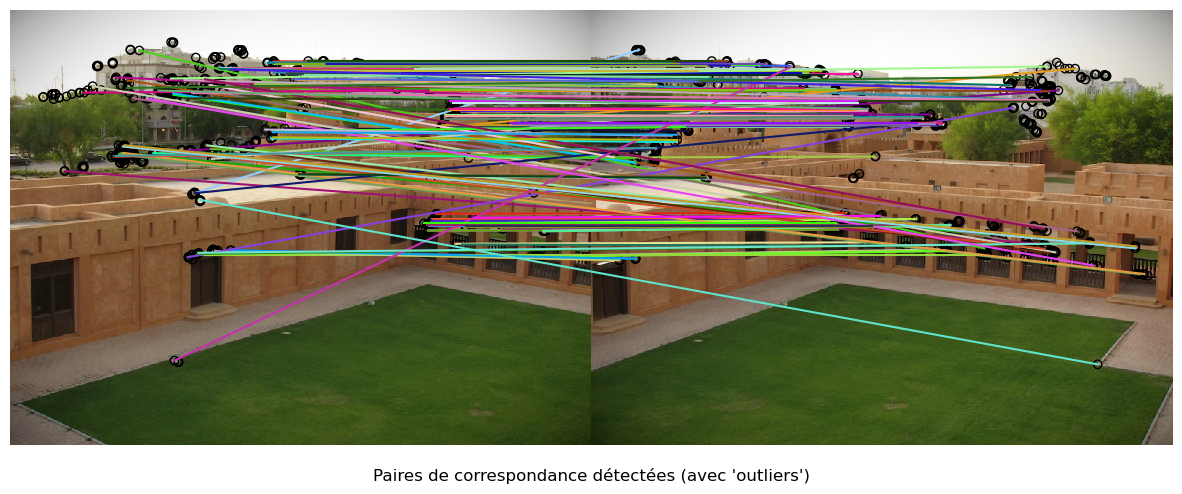

In [2]:
import cv2
from utils import plot_matches

# Commençant par charger deux images
img1 = cv2.imread('resources/al_ain/Image1.jpg')
img2 = cv2.imread('resources/al_ain/Image2.jpg')

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

imgs = [img1, img2]

# construisons l'objet orb pour la detection, description
orb = cv2.ORB_create()

# détection des points-clés et construction des
# descripteurs associés
keypoints_list   = []  # keypoints[i] corresponds to imgs[i]
descriptors_list = []  # descriptors[i] corresponds to keypoints[i]
for img in imgs:
    # trouver les points-clés et leurs descripteurs
    keypoints, descriptors = orb.detectAndCompute(img, None)

    keypoints_list.append(keypoints)
    descriptors_list.append(descriptors)

# construction de l'objet BFMatcher pour la mise en correspondance
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# matches_list[i] décrit la paire de correspondance entre les descripteurs descriptors[i] et descriptors[i+1]
matches_list = []
for pair in zip(descriptors_list[:-1], descriptors_list[1:]):
    matches = bf.match(pair[0], pair[1])
    matches_list.append(matches)

# Affichage des points-clés détectés pour les deux premières images
cvKeypoints1 = keypoints_list[0]
cvKeypoints2 = keypoints_list[1]

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15, 12))

tmp = cv2.drawKeypoints(img1, cvKeypoints1, None, color=(0,0,255), flags=0)
ax1.imshow(tmp)
ax1.axis('off')
ax1.set_title('Points-clés détectés dans Image 1', y=-0.10)

tmp = cv2.drawKeypoints(img2, cvKeypoints2, None, color=(0,0,255), flags=0)
ax2.imshow(tmp)
ax2.axis('off')
ax2.set_title('Points-clés détectés dans Image 2', y=-0.10)
plt.show()

# traçons les correspondances...
fig, ax = plt.subplots(1, 1, figsize=(15, 12))
ax.axis('off')

matches = np.array([ (m.queryIdx, m.trainIdx) for m in matches_list[0] ])

plot_matches(ax, img1, img2, cvKeypoints1, cvKeypoints2, matches,
                 keypoints_color='k', matches_color=None, only_matches=False)
plt.title('Paires de correspondance détectées (avec \'outliers\')', y=-0.10)
plt.show()

## 4. Les tâches

### 4.1. Estimation de la matrice de transformation [TODO 1] (10 points)

Nous avons maintenant une liste de points clés correspondants sur les deux images. Nous allons l'utiliser pour trouver une matrice de transformation qui mappe les points de la première image aux coordonnées correspondantes dans la deuxième image. En d'autres termes, si le point $p_1 = \left(x_1,y_1\right)$ dans l'image 1 correspond à $p_2=\left(x_2,y_2\right)$ dans l'image 2, nous devons trouver une matrice de transformation $\mathbf{H}$ telle que :

$$
\tilde{p_1}\mathbf{H}^T = \tilde{p_2},
$$

où $\tilde{p_1}$ et $\tilde{p_2}$ sont les coordonnées homogènes associées à $p_1$ et $p_2$.

Notez qu'il peut être impossible de trouver la transformation $\mathbf{H}$ qui mappe chaque point de l'image 1 **exactement** au point correspondant de l'image 2. Cependant, nous pouvons estimer la matrice de transformation avec les moindres carrés ou la décomposition en valeurs singulières. Étant donné $N$ paires de points-clés correspondants, soit $\mathbf{X_1}$ et $\mathbf{X_2}$ des matrices $ N \times 3 $ dont les lignes sont des coordonnées homogènes des points clés correspondants dans l'image 1 et l'image 2 respectivement. Nous pouvons estimer $\mathbf{H}$ en résolvant le problème des moindres carrés,

$$
\mathbf{X_1}\,\mathbf{H}^T = \mathbf{X_2}
$$

Dans la fonction **`fit_transform_matrix()`** du fichier` panorama.py`, implémentez le code pour estimer la matrice de transformation $\mathbf{H}$ à partir des coordonnées des points-clés appariés $p_1$ et $p_2$.

- **Indication** : Consultez les slides n° 12 et 40 du cours "[alignement des images](https://benhadid.github.io/m1vpo/lectures/)".

In [5]:
from panorama import fit_transform_matrix

#
# testq de validité pour fit_transform_matrix()
#

# première image -- coordonnées organisées en ( y , x )
p0 = np.array([[0.0, 0.0],       # coin supérieur gauche
               [0.0, 1.0],       # coin supérieur droit
               [1.0, 0.0],       # coin inférieur gauche
               [1.0, 1.0]])      # coin inférieur droit

# deuxième image (première image pivotée de 45°)
v  = np.sqrt(2)/2.
p1 = np.array([[ 0.0, 0.0],
               [   v,   v],
               [   v,  -v],
               [ v+v, 0.0]])

#troisième image (première image agrandie deux fois horizontalement)
p2 = np.array([[ 0.0, 0.0],
               [ 0.0, 2.0],
               [ 1.0, 0.0],
               [ 1.0, 2.0]])

#quatrième image (première image projetée par Homographie)
p3 = np.array([[ 4.3,   7.3],
               [ 8.2,   7.2],
               [ 4.6,  10.7],
               [ 9.2,   9.2]])

# premier test
H1 = fit_transform_matrix(p0[:,[1,0]], p0[:,[1,0]])    #( [:, [1,0] ] <-> permutation des colonnes y et x)
H1 = H1 / H1[2,2]

# sortie attendue : la matrice identité
sol1 = np.eye(3)

#second test
H2 = fit_transform_matrix(p0[:,[1,0]], p1[:,[1,0]])
H2 = H2 / H2[2,2]

# sortie attendue : matrice de rotation (45°)
sol2 = np.array([[ v, -v, 0],
                 [ v,  v, 0],
                 [ 0,  0, 1]])

#troisième test
H3 = fit_transform_matrix(p0[:,[1,0]], p2[:,[1,0]])
H3 = H3 / H3[2,2]

# sortie attendue : matrice de changement d’échelle np.diag(2, 1, 1)
sol3 = np.array([[ 2.0,  0.0, 0],
                 [ 0.0,  1.0, 0],
                 [ 0.0,  0.0, 1]])

#quatrième test
H4 = fit_transform_matrix(p0[:,[1,0]], p3[:,[1,0]])
H4 = H4 / H4[2,2]

# sortie attendue : matrice Homographie standard (non-affine)
sol4 = np.array([[ 3.52692,  0.6,      7.3    ],
                 [ 8.03065, -0.90374,  4.3    ],
                 [ 0.50374, -0.26168,  1.     ]])

# comparaison des résultats
if  np.allclose(sol1, H1, rtol=1e-05, atol=1e-05):
    print('test identité   :  correct ! ')
else:
    print('test identité   :  incorrect !\nH = %s, \n\nsol = %s\n' % (H1,sol1))

if  np.allclose(sol2, H2, rtol=1e-05, atol=1e-05):
    print('test rotation   :  correct ! ')
else:
    print('test rotation   :  incorrect !\nH = %s, \n\nsol = %s\n' % (H2,sol2))

if  np.allclose(sol3, H3, rtol=1e-05, atol=1e-05):
    print('test échelle    :  correct ! ')
else:
    print('test échelle    :  incorrect !\nH = %s, \n\nsol = %s\n' % (H3,sol3))

if  np.allclose(sol4, H4, rtol=1e-05, atol=1e-05):
    print('test projection :  correct ! ')
else:
    print('test projection :  incorrect !\nH = %s, \n\nsol = %s\n' % (H4,sol4))

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

### 4.2. Alignement des images à l'aide de RANSAC [TODO 2] (20 points)
Au lieu d'utiliser directement toutes nos correspondances de points-clés comme entrée pour la fonction `fit _transform_ matrix()`, il est préférable de sélectionner uniquement les points-clés valides (c.-à-d. les 'inliers') pour calculer la matrice de transformation $\mathbf{H}$. Nous utiliserons l'algorithme RANSAC ([RANdom SAmple Consensus](https://en.wikipedia.org/wiki/Random_sample_consensus)) pour cette tâche. Cet algorithme est modelé selon une approche probabiliste qui permet de classer les correnspondances entre points-clés en deux catégories : Les bonnes correspondances (inliers), et les mauvaises correspondances (outliers). Les étapes dans RANSAC sont énumérés comme suit :
1. Sélectionner, d'une manière aléatoire, un sous-ensemble de points-clés (c.-à-d. quatre paires) dans l'ensemble des correspondances $C$.   
2. Calculer une matrice de transformation $\hat{\mathbf{H}}$ à partir du sous-ensemble sélectionné.
3. Appliquer la matrice $\hat{\mathbf{H}}$ à l'ensemble complémentaire $\bar{C}$ et determiner les bonnes correspondances (inliers) selon un seuil prédéfini.
4. Répéter les étapes 1&ndash;3 plusieurs fois et conserver la matrice  $\hat{\mathbf{H}}$ qui produit le plus grand nombre de bonnes correspondances avec une confidence $\geq 99.9\%$.
5. Recalculer une meilleure estimation de la matrice $\hat{\mathbf{H}}$ en utilisant que les paires de points-clés classées comme &laquo; bonnes correspondances &raquo; (c.-à-d. les 'inliers').

Implémentez la fonction **`ransac()`** dans` panorama.py`. Puis, exécutez le code suivant pour validation.

In [ ]:
from panorama import ransac

# récupérer les coordonnées des points clés depuis les structures opencv
keypoints1 = np.squeeze( np.array( [  kp.pt  for kp in cvKeypoints1 ] ) )
keypoints2 = np.squeeze( np.array( [  kp.pt  for kp in cvKeypoints2 ] ) )

# lancer RANSAC
H, robust_matches = ransac(keypoints1, keypoints2, matches)

# Visualisation des correspondances robustes retournées par RANSAC
_, ax = plt.subplots(1, 1, figsize=(15, 12))
plot_matches(ax, img1, img2, cvKeypoints1, cvKeypoints2, robust_matches)
plt.axis('off')
plt.title('RANSAC (résultat)', y=-0.10)
plt.show()

plt.subplots(1, 1, figsize=(15, 12))
plt.imshow(cv2.cvtColor(cv2.imread('ransac.png'), cv2.COLOR_BGR2GRAY))
plt.axis('off')
plt.title('RANSAC (référence)', y=-0.10)
plt.show()

### 4.3. Projection inverse des images et interpolation bilineaire [TODO3] (40 points)

Nous pouvons maintenant utiliser la matrice de transformation $\mathbf{H}$ calculée à l'aide de RANSAC pour transformer nos images et créer un panorama ! En ce sens, nous avons besoin d'implémenter une méthode qui projette les coordonnées de chaque pixel dans l'image source vers les coordonnées transformées dans l'image destination.

Dans ce devoir, la fonction **`warp_image()`** dans `panorama.py` doit réaliser l'étape de "projection inverse avec interpolation bilinéaire" présentée dans le cours "[Images panoramiques](https://benhadid.github.io/m1vpo/lectures/)". C-à-d. Pour transformer les pixels de l'image source, nous commencerons à partir des coordonnées de l'image destination et nous utiliserons l'interpolation bilinéaire dans l'image source pour calculer les couleurs des pixels à reproduire dans l'image destination.

Une fois la fonction **`warp_image()`** implémentée, exécutez le code ci-dessous pour effectuer l'étape de projection.

**Indications :**
- Lorsque vous manipulez des coordonnées homogènes, n'oubliez pas de les normaliser avant de les reconvertir en coordonnées cartésiennes.
- Attention aux points en dehors de l'image source lors de la projection inverse. Ils ne doivent pas être inclus dans les calculs de l'image cible.
- Commencez par travailler sur le code en bouclant sur chaque pixel d'une manière itérative (approche classique). Ensuite, vous pouvez optimiser votre code en utilisant des instructions Numpy/Scipy (pensez à utiliser `numpy.meshgrid`).


In [ ]:
from panorama import get_output_space, warp_image

#left on right
transforms = [H , np.eye(3) ]

#right on left
#transforms = [np.eye(3), np.linalg.inv(H)  ]

# 'get_output_space' est une fonction auxiliaire qui aide
# à trouver le cadre global associé à une liste d'images transformées
output_shape, offset = get_output_space(imgs, transforms)

# transformation des images
img1_warped, _ = warp_image(imgs[0], transforms[0], output_shape, offset)
img2_warped, _ = warp_image(imgs[1], transforms[1], output_shape, offset)

# Visualisation des images transformées
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15, 12))
ax1.imshow(img1_warped[:,:,:3])
ax1.axis('off')
ax1.set_title('Image 1 projetée (résultat)',y=-0.10)

ax2.imshow(img2_warped[:,:,:3])
ax2.axis('off')
ax2.set_title('Image 2 projetée (résultat)',y=-0.10)
plt.show()

plt.subplots(1, 1, figsize=(15, 12))
plt.imshow(cv2.cvtColor(cv2.imread('warped.png'), cv2.COLOR_BGR2GRAY))
plt.axis('off')
plt.show()

### 4.4. Assemblage (naïve) des images [TODO 4] (5 points)

Une fois les images transformées, il reste à les assembler en une seule image panoramique. Une méthode simple (et naïve) est d'additionner les deux images. Ainsi, pour chaque pixel $\left[i,j\right]$ dans l'image de destination, nous avons :

$$
dst[i,j] = \left(src_1\left[i,j\right] + src_2\left[i,j\right]\right) \bigg/ \sum_{k=1}^{2} alpha_k\left[i,j\right]
$$

où
- $src_1[i,j]$ et $src_2[i,j]$ sont respectivement les couleurs des pixels dans les images $src_1$ et $src_2$.
- $alpha_1$ et $alpha_2$ sont les canaux de transparence associés à ces images.

Implémentez la fonction **``naive_fusion()``** dans `panorama.py` puis exécutez le code suivant pour validation. Le panorama obtenu présentera sans doute des artéfacts de bords, mais nous verrons plus tard comment obtenir un meilleur résultat.

In [ ]:
from panorama import naive_fusion

src1_warped = loaded['img1_warped']
src2_warped = loaded['img2_warped']

#décommentez les deux lignes suivantes pour tester la fonction naive_fusion() sur vos images (au lieu des images références).
#src1_warped = img1_warped
#src2_warped = img2_warped

merged = naive_fusion(src1_warped, src2_warped)

plt.subplots(1, 1, figsize=(15, 12))
plt.imshow(merged)
plt.axis('off')
plt.title("Fusion d'images - alpha moyen (résultat)", y=-0.10)
plt.show()

plt.subplots(1, 1, figsize=(15, 12))
plt.imshow(cv2.cvtColor(cv2.imread('merged.png'), cv2.COLOR_BGR2GRAY))
plt.axis('off')
plt.title("Fusion d'images - alpha moyen (référence)", y=-0.10)
plt.show()

### 4.5. Cartes de pondération [TODO 5] (20 points)
Vous avez sans doute remarqué les filons désagréables au milieu de votre image panoramique. Il est possible de lisser ces artefacts et produire une image plus agréable à l'oeil en utilisant une technique très simple appelée "contour progressif" (*anglais* : feathering). Actuellement, tous les pixels de la région de chevauchement des images sont pondérés de manière égale (c.-à-d. le canal alpha de l'image = 0.5). Cependant, comme les pixels aux extrémités de la zone de chevauchement sont très bien complétés par les pixels de l'autre image, nous pouvons faire en sorte qu'ils contribuent moins au signal dans le panorama final.

<img src="feathering.png"/>

Le mélange par "contour progressif" peut être appliqué aux images en trois étapes :
1. Calcul d'une carte de pondération pour chaque image à fusionner : Pondération de chaque pixel de l'image source proportionnellement à sa distance du bord. Les pixels au milieu de l'image ont un poids plus important par rapport aux pixels aux bords de l'image.  
2. Application des cartes de pondérations aux images correspondantes
3. Pour chaque pixel dans l’image fusionnée finale, division de la valeur du pixel (c.-à-d. la couleur)
   par la sommes des coefficients de pondération à cet pixel.

En ce sens, réécrivez la fonction **`warp_image`** dans `panorama.py` pour qu'elle calcule, en plus de la transformation initialement implémentée, la carte de pondération des alphas de l'image transformée selon la technique du contour progressif. Le calcul des coefficients de pondération doit être contrôlé par un paramètre supplémentaire appelé `method` où :
 - method = None     -- aucun changement. La fonction retourne des images avec le canal alpha égale à 1.0 (TODO4).
 - method ='hlinear' -- calcul des coefficients de pondération de l'image transformée dans le sens horizontal seulement
 - method ='vlinear' -- calcul des coefficients de pondération de l'image transformée dans le sens vertical seulement
 - method ='linear'  -- calcul des coefficients de pondération de l'image transformée dans le sens horizontal et vertical.

Exécutez le code suivant pour visualiser les cartes de pondération obtenues à l'aide de la technique du "contour progressif".

In [ ]:
limg1_warped, m1 = warp_image(imgs[0], transforms[0], output_shape, offset, method='linear')
limg2_warped, m2 = warp_image(imgs[1], transforms[1], output_shape, offset, method='linear')

# Visualisation des cartes de pondérations
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15, 12))
ax1.imshow(limg1_warped[:,:,3], cmap='gray')
ax1.axis('off')
ax1.set_title('Carte de pondération de Image 1 (résultat)',y=-0.10)

ax2.imshow(limg2_warped[:,:,3], cmap='gray')
ax2.axis('off')
ax2.set_title('Carte de pondération de Image 2 (résultat)',y=-0.10)
plt.show()

plt.subplots(1, 1, figsize=(15, 12))
plt.imshow(cv2.cvtColor(cv2.imread('alpha.png'), cv2.COLOR_BGR2GRAY))
plt.axis('off')
plt.show()

### 4.6. Assemblage avec pondération des images [TODO 6] (5 points)

Maintenant que nous ayons des cartes de pondération plus adaptées, nous pouvons fusioner les images transformées `img1_warped` et `img2_warped`  selon la formule suivante :

$$
dst[i,j] = \left( alpha_1\left[i,j\right] \times src_1\left[i,j\right] + alpha_2\left[i,j\right] \times src_2\left[i,j\right]\right) \bigg/ \sum_{k=1}^{2} alpha_k\left[i,j\right]
$$

Implémentez la fonction **``fusion()``** dans `panorama.py` qui réalise cette opération, puis exécutez le code ci-dessous pour validation.

In [ ]:
from panorama import fusion

src1_warped = loaded['limg1_warped']
src2_warped = loaded['limg2_warped']
lm1         = loaded['m1']
lm2         = loaded['m2']

#décommentez les quatre lignes suivantes pour tester la fonction fusion() sur vos données (au lieu des données références).
#src1_warped = limg1_warped
#src2_warped = limg2_warped
#lm1 = m1
#lm2 = m2

merged = fusion(src1_warped, lm1, src2_warped, lm2)

plt.subplots(1, 1, figsize=(15, 12))
plt.imshow(merged)
plt.axis('off')
plt.title("fusion avec lissage des bordures (résultat)", y=-0.10)
plt.show()

plt.subplots(1, 1, figsize=(15, 12))
plt.imshow(cv2.cvtColor(cv2.imread('fused.png'), cv2.COLOR_BGR2GRAY))
plt.axis('off')
plt.title("fusion avec lissage de bordure (référence)", y=-0.10)
plt.show()

### 5. Fusion d'images multiples dans un panorama [TODO  Bonus] (20 points)

Étant donné une séquence ordonnée d'images ($I_1, I_2,...,I_m,\text{ où } m \geq 2$), nous aimerions produire un panorama à partir de cette séquence. En ce sens, implémentez la fonction **`stitch_multiple_images()`** dans `panorama.py` qui réalise cette opération.


**Indications :**

- Pensez à réutiliser les fonctions que vous avez déjà implémentées dans `panorama.py`.
- Les transformations des images $I_{i}$ pour produire l'image panoramique finale doivent être référencées par rapport à l'image $I_{ref}$ &ndash; C.-à-d. le 'milieu' de votre image panoramique est indiqué par le paramètre `imgref` de la fonction `stitch_multiple_images()`.
  - Prenez chaque paire d'images voisine et calculez la matrice de transformation $\mathbf{H}_i$ qui convertit les coordonnées des pixels dans l'image $I_{i}$ aux nouvelles coordonnées dans l'image $I_{i+1}$.
  - Appliquez ensuite les opérations algébriques nécessaires pour réadapter ces transformations par rapport à l'image référence $I_{ref}$. Si vous êtes confus, vous pouvez revoir les slides du cours sur les transformations géométriques et comment les combinées pour effectuer une transformation complexe à partir d'une suite de transformations élémentaires.
  - L'inverse de la matrice de transformation $\mathbf{H}$ a l'effet inverse.

In [ ]:
from panorama import stitch_multiple_images

# Load images to stitch
img1 = cv2.imread('resources/city/01.jpg')
img2 = cv2.imread('resources/city/02.jpg')
img3 = cv2.imread('resources/city/03.jpg')
img4 = cv2.imread('resources/city/04.jpg')
img5 = cv2.imread('resources/city/05.jpg')

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
img4 = cv2.cvtColor(img4, cv2.COLOR_BGR2RGB)
img5 = cv2.cvtColor(img5, cv2.COLOR_BGR2RGB)

imgs = [img1, img2, img3, img4, img5]

keypoints_list   = []  # keypoints[i] associated with imgs[i]
descriptors_list = []  # descriptors[i] associated with keypoints[i]
for img in imgs:
    # find the keypoints and descriptors with ORB
    keypoints, descriptors = orb.detectAndCompute(img, None)
    keypoints = np.squeeze( np.array( [  kp.pt  for kp in keypoints ] ) )

    keypoints_list.append(keypoints)
    descriptors_list.append(descriptors)

# matches_list[i] décrit la paire de correspondance entre les descripteurs descriptors[i] et descriptors[i+1]
matches_list = []
for pair in zip(descriptors_list[:-1], descriptors_list[1:]):
    # find the matches between the sets of descriptors (and thus keypoints)
    matches = bf.match(pair[0], pair[1])
    matches = np.array( [ (m.queryIdx, m.trainIdx) for m in matches ] )

    matches_list.append( matches )

# Stitch images together
panorama = stitch_multiple_images(imgs, keypoints_list, matches_list, imgref=2, blend='linear')

# Plot initial images
_, ax = plt.subplots(1, len(imgs), figsize=(15, 12))
for i, img in enumerate(imgs):
    ax[i].imshow(img[:,:,:3])
    ax[i].axis('off')
plt.show()

# show panorama image
plt.subplots(1, 1, figsize=(15, 12))
plt.imshow(panorama)
plt.axis('off')
plt.title("Image panoramique (résultat)", y=-0.10)
plt.show()

plt.subplots(1, 1, figsize=(15, 12))
plt.imshow(cv2.cvtColor(cv2.imread('panorama.png'), cv2.COLOR_BGR2GRAY))
plt.axis('off')
plt.title("Image panoramique (référence)", y=-0.10)
plt.show()

## 5. Livrables

### 5.1. Le code (à remettre sur [benhadid.ddns.net](https://benhadid.ddns.net/course/M1_VPO/hw2))

Le fichier "devoir3.zip" contenant le fichier **`panorama.py`** modifié dans les zones indiquées par `#TODO-BLOC-DEBUT` et `#TODO-BLOC-FIN`.

**Le code sera remis <del>en classe pendant votre séance de TP</del> au serveur INGInious - <span style='color:Red'> aucun document ou code ne sera accepté si envoyé par mail ou clé USB</span>**.



In [ ]:
# Exécutez cette cellule puis récupérez votre fichier "devoir3.zip" depuis le panneau gauche dans Colab
# Si nécessaire, faites un 'refresh' sur le répertoire pour faire apparaître le fichier 'devoir3.zip'

!zip -r ./devoir3.zip panorama.py